In [1]:
import numpy as np
import matplotlib.pyplot as plt
import galois
import itertools
from classical_code import *
from quantum_code import *
import stim
from scipy.sparse import lil_matrix
import scipy as sp
from ldpc import BpDecoder, BpOsdDecoder
from ldpc.bplsd_decoder import BpLsdDecoder
from tqdm import tqdm
from result_lifetime import Result, save_new_res
# %load_ext snakeviz

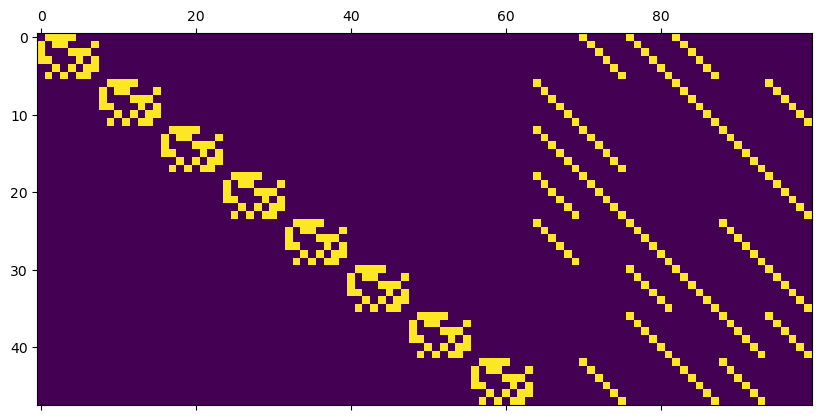

In [235]:
hgp_qcode = read_qcode("../codes/qcodes/HGP_100_4/HGP_100_4.qcode")
qcode = hgp_qcode
# qcode = read_qcode("../codes/qcodes/HGP_100_4/HGP_C422_200_4.qcode")


# hgp_qcode = read_qcode("../codes/qcodes/HGP_400_16/HGP_400_16.qcode")
# qcode = hgp_qcode
# qcode = read_qcode("../codes/qcodes/HGP_400_16/HGP_C422_800_16.qcode")


# hgp_qcode = read_qcode("../codes/qcodes/HGP_900_36/HGP_900_36.qcode")
# qcode = hgp_qcode
# qcode = read_qcode("../codes/qcodes/HGP_900_36/HGP_C422_1800_36.qcode")

# hgp_qcode = read_qcode("../codes/qcodes/HGP_1600_64/HGP_1600_64.qcode")
# qcode = hgp_qcode

# qcode = read_qcode("../codes/qcodes/HGP_C642_2400_64.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_C422_3200_64.qcode")

# qcode = read_qcode("../codes/qcodes/HGP_STEANE_700_4.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_STEANE_2800_16.qcode")


# concatenate_iceberg(qcode, 6, "../codes/qcodes/")
# concatenate_iceberg(qcode, 4, "../codes/qcodes/")
# concatenate_steane(qcode, "../codes/qcodes/")


hgp_Hx, hgp_Hz, hgp_Lx, hgp_Lz, _ = hgp_qcode.to_numpy()
Hx, Hz, Lx, Lz, mapping = qcode.to_numpy()


qubit_error_rate = 0.04
meas_error_rate = 0.0

stab_type = False
tanner = True if meas_error_rate else False

H = Hx if stab_type else Hz
hgp_H = hgp_Hx if stab_type else hgp_Hz

qed_dec_H = H[:qcode.qedxm]
qed_channel_probs = [qubit_error_rate]*H.shape[1]

qec_aug_dec_H = np.hstack([hgp_H, np.eye(hgp_H.shape[0], dtype=int)])
qec_aug_channel_probs = [qubit_error_rate]*hgp_H.shape[1] + [meas_error_rate]*(hgp_H.shape[0])

qec_dec_H = hgp_H
qec_channel_probs = [qubit_error_rate]*hgp_H.shape[1]
L = Lx if stab_type else Lz

plt.matshow(qec_dec_H)
# print(np.count_nonzero(Hx, axis=1))

In [236]:
overlapping_x_generators = np.empty(qcode.qedxm, dtype=object)
for i in range(qcode.qedxm):
    tmp = np.array([], dtype=int)
    for j in range(qcode.qedxm,qcode.xm):
        if np.any(Hx[i] & Hx[j]): tmp = np.append(tmp, j)
    overlapping_x_generators[i] = tmp

overlapping_z_generators = np.empty(qcode.qedxm, dtype=object)
for i in range(qcode.qedzm):
    tmp = np.array([], dtype=int)
    for j in range(qcode.qedzm,qcode.zm):
        if np.any(Hz[i] & Hz[j]): tmp = np.append(tmp, j)
    overlapping_z_generators[i] = tmp

def get_overlapping(measurements, gen_type=False, not_overlapping=False):
    overlapping_generators = overlapping_x_generators if gen_type else overlapping_z_generators
    gens_to_measure = set()
    for g in np.where(measurements)[0]:
        gens_to_measure |= set(overlapping_generators[g])

    if not_overlapping:
        return np.array(list(set(np.arange(qcode.qedxm,qcode.xm)) ^ gens_to_measure), dtype=int)
    else:
        return np.array(list(gens_to_measure), dtype=int)

def iceberglogicals(n):
    icebergX = np.zeros(shape=(n-2,2), dtype=int)
    icebergZ = np.zeros(shape=(n-2,2), dtype=int)

    for i in range(n-2):
        icebergX[i] = np.array([0,i+1])
        icebergZ[i] = np.array([i+1,n-1])

    return icebergX, icebergZ
icebergX, icebergZ = iceberglogicals(4)

In [237]:
qec_aug_dec = BpLsdDecoder(
    qec_aug_dec_H,
    channel_probs=qec_aug_channel_probs,
    bp_method="ms",
    max_iter=30,
    osd_method="osd0",
    # osd_order=4 #the osd search depth
)

qec_dec = BpLsdDecoder(
    qec_dec_H,
    channel_probs=qec_channel_probs,
    bp_method="ms",
    max_iter=30,
    osd_method="osd_cs",
    osd_order=4 #the osd search depth
)

def decode(curr_synd, augment, concat):
    guessed_error = np.zeros(H.shape[1], dtype=int)

    if (concat == 0):
        # QEC only
        if augment:
            guessed_error ^= qec_aug_dec.decode(curr_synd[qcode.qedzm:])[:hgp_H.shape[1]]
        else:
            guessed_error ^= qec_dec.decode(curr_synd[qcode.qedzm:])
    elif (concat == 1):
        # QED + QEC
        curr_qed_synd = curr_synd[:qcode.qedxm]
        curr_hgp_synd = curr_synd[qcode.qedxm:]

        block_correction = np.array([0,0,0,1], dtype=int) if stab_type else np.array([1,0,0,0], dtype=int)
        corrections = np.concatenate([block_correction if x == 1 else np.zeros(4, dtype=int) for x in curr_qed_synd])
        guessed_error ^= corrections

        #######################
        new_channel_probs = 0.0003 * np.ones(hgp_H.shape[1])
        new_channel_probs[mapping[curr_qed_synd == 1].flatten()] = 0.25
        if augment:
            new_channel_probs = np.concatenate([new_channel_probs, [meas_error_rate]*hgp_H.shape[0]])
            qec_aug_dec.update_channel_probs(new_channel_probs)
        else:
            qec_dec.update_channel_probs(new_channel_probs)
        ########################

        if augment:
            logical_correction = qec_aug_dec.decode(curr_hgp_synd)[:hgp_H.shape[1]]
        else:
            logical_correction = qec_dec.decode(curr_hgp_synd)[:hgp_H.shape[1]]

        physical_correction = np.zeros(Hx.shape[1], dtype=int)

        for c in np.where(logical_correction)[0]:
                iceberg_block = np.where(mapping == c)[0][0]
                iceberg_log = np.where(mapping == c)[1][0]
                if stab_type:
                        physical_correction[icebergZ[iceberg_log]+(4*iceberg_block)] ^= 1
                else:
                        physical_correction[icebergX[iceberg_log]+(4*iceberg_block)] ^= 1

        guessed_error ^= physical_correction
    return guessed_error

In [238]:
# np.random.seed(0)

num_iters = 1000
num_rounds = 10
concat = 1 if qcode.qedxm else 0
adaptive = 0
successes = 0

for ii in tqdm(range(1,num_iters+1)):
    curr_qubit_error = np.zeros(H.shape[1], dtype=int)

    success = 1
    for jj in range(num_rounds):
        new_qubit_error = np.random.choice([0, 1], size=H.shape[1], p=[1-qubit_error_rate, qubit_error_rate])
        new_synd_error = np.random.choice([0, 1], size=H.shape[0], p=[1-meas_error_rate, meas_error_rate])
        curr_qubit_error ^= new_qubit_error

        curr_synd = ((H @ curr_qubit_error) % 2) ^ new_synd_error
        curr_qubit_error ^= decode(curr_synd, tanner, concat)

    curr_synd = ((H @ curr_qubit_error) % 2)
    curr_qubit_error ^= decode(curr_synd, 0, concat)

    obs = (L @ curr_qubit_error) % 2

    if np.any(obs):
        success = 0

    successes += success

print(successes/num_iters)
print()

100%|██████████| 1000/1000 [00:01<00:00, 737.58it/s]

0.165



In [31]:
successes

1